In [1]:
import os
import git
import sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)

from abm_vec.one_period_sim import run_sim
from abm_vec.initialization import get_bank_data

from scipy.optimize import minimize
from scipy.stats import kstest
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from abm_vec.essentials.util import get_git_root_directory
import numpy as np
import random
from scipy import stats

In [2]:
bank_data = get_bank_data()

In [3]:
len(bank_data['equity'])

80

# Minimize the KS distance first

In [4]:
def fun(x):

    param = {'firm_lb1': x[0],
             'firm_lb2': x[1],
             'firm_ub1': x[2],
             'firm_ub2': x[3],
             'firm_alpha1': x[4],
             'firm_alpha2': x[5],
             'firm_rho': x[6],
             'min_productivity': x[7]}
    results = run_sim(param, copy.deepcopy(bank_data), [1]) 
    empirical_le_ratio = results[0]['banks']['bank_loans'] / results[0]['banks']['bank_equity']
    simulated_le_ratio = results[1]['banks']['bank_loans'] / results[0]['banks']['bank_equity']
    max_diff = kstest(empirical_le_ratio, simulated_le_ratio, alternative='two-sided').statistic 
    return max_diff#np.average([(x-y)**2 for x,y in zip(empirical_le_ratio, simulated_le_ratio)])

In [5]:
bounds = [(5 * 10 ** 5, 5 * 10 ** 6),
          (10 ** 3, 10**4),
          (5 * 10** 7, 30 * 10 ** 7),
          (5 * 10 ** 5, 10 ** 7),
          (0, 3),
          (0, 3),
          (0, 1) ,
          (100, 1000)]#,
          #(50, 2000)]

initial_guess = [10**6, 7500, 15 * 10 ** 7, 0.7 * 10 ** 6, 1.6, 1.7, 0.9, 150]#, 820]


result = minimize(fun, initial_guess, method='Nelder-Mead', bounds=bounds)

In [6]:
optimal_x = result.x

In [7]:
optimal_x

array([9.87030029e+05, 7.81471252e+03, 1.51020813e+08, 6.98611450e+05,
       1.66713867e+00, 1.66508484e+00, 9.37765503e-01, 1.40844727e+02])

In [4]:
optimal_x = np.array([9.87030029e+05, 7.81471252e+03, 1.51020813e+08, 6.98611450e+05,
       1.66713867e+00, 1.66508484e+00, 9.37765503e-01, 1.40844727e+02])

In [5]:
result.fun

NameError: name 'result' is not defined

# Generate 1000 samples and apply the k-sample Anderson test

In [13]:
def fun(x):
    param = {'firm_lb1': x[0],
             'firm_lb2': x[1],
             'firm_ub1': x[2],
             'firm_ub2': x[3],
             'firm_alpha1': x[4],
             'firm_alpha2': x[5],
             'firm_rho': x[6],
             'min_productivity': x[7]}
    random_seeds = random.sample(range(1, 100000), 1000)
    results = run_sim(param, copy.deepcopy(bank_data), random_seeds) 
    empirical_le_ratio = [s[0]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]
    simulated_le_ratio = [s[1]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]
    return empirical_le_ratio, simulated_le_ratio

In [14]:
empirical_le_ratio, simulated_le_ratio = fun(optimal_x)

In [15]:
from scipy.stats import anderson_ksamp

In [16]:
res = anderson_ksamp(simulated_le_ratio)

/tmp/ipykernel_17741/2577826661.py:1: UserWarning: p-value capped: true value larger than 0.25
  res = anderson_ksamp(simulated_le_ratio)


In [17]:
res.pvalue

0.25

In [18]:
# KS independent

In [19]:
# ks test
res = [kstest(empirical_le_ratio[0], r, alternative='two-sided').pvalue for r in simulated_le_ratio]

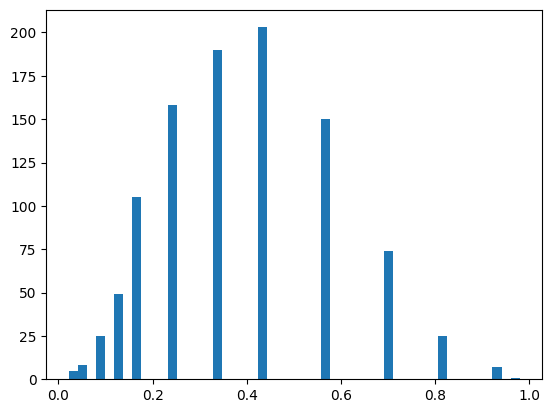

In [20]:
plt.hist(res, bins=50)
plt.show()

# Price optimization

In [8]:
# all parameters at once
x = np.array([9.87030029 * 10 ** 5, 7.81471252 * 10 ** 3, 1.51020813 * 10 ** 8, 6.98611450 * 10 ** 5,
       1.66713867, 1.66508484e+00, 0.937765503, 1.40844727 * 10 ** 2])

param = {'firm_lb1': x[0],
         'firm_lb2': x[1],
         'firm_ub1': x[2],
         'firm_ub2': x[3],
         'firm_alpha1': x[4],
         'firm_alpha2': x[5],
         'firm_rho': x[6],
         'min_productivity': x[7],
         'market_price': 600,
         "good_consumption": [0.98, 0.94],
         "good_consumption_std": [0.006, 0.006],
         "min_consumption": 0.9,
         "max_consumption": 1}
#results = run_sim(param, copy.deepcopy(bank_data), [1]) 

In [9]:
def update_param(param, new):
    param_new = param.copy()
    param_new.update(new)
    return param_new

In [10]:
min_prices_threshold = [run_sim(update_param(param, {'market_price': x}), copy.deepcopy(bank_data), [1])[1]['firms']['min_price_breach'] for x in np.linspace(100, 1000, 20)]

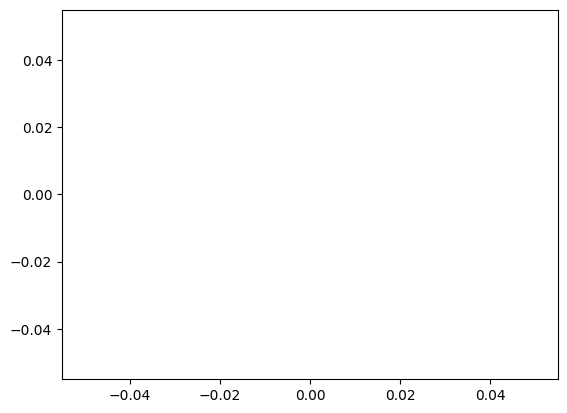

In [11]:
plt.plot(np.linspace(100, 1000, 20), min_prices_threshold)
plt.show()

In [198]:
param = {'firm_lb1': x[0],
         'firm_lb2': x[1],
         'firm_ub1': x[2],
         'firm_ub2': x[3],
         'firm_alpha1': x[4],
         'firm_alpha2': x[5],
         'firm_rho': x[6],
         'min_productivity': x[7],
         'market_price': 600,
         "good_consumption": [0.88, 0.83],
         "good_consumption_std": [0.01, 0.01],
         "min_consumption": 0.7,
         "max_consumption": 1}
results = run_sim(param, copy.deepcopy(bank_data), [1]) 

In [202]:
len([x for x in results[1]["firms"]["firm_credit_demand"] if x>0])

KeyError: 'firms'

In [200]:
len(results[1]['firms']['defaulting_firms'])

201

In [186]:
len(results[1]['banks']['defaulted_banks'])

0

In [187]:
results[1]['firms']['min_price_breach']

0.7493509087277811

(array([  11.,   41.,  301., 1127., 2453., 2821., 2090.,  932.,  200.,
          24.]),
 array([575.4690685 , 580.0223154 , 584.57556231, 589.12880921,
        593.68205611, 598.23530302, 602.78854992, 607.34179683,
        611.89504373, 616.44829064, 621.00153754]),
 <BarContainer object of 10 artists>)

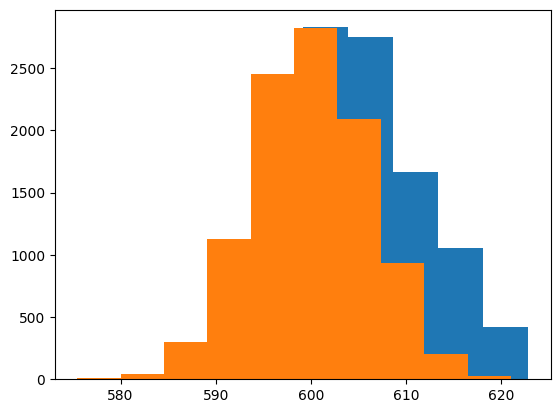

In [188]:
plt.hist(results[1]['firms']['firm_price'])
plt.hist(results[0]['firms']['firm_price'])

# Multi simulation analysis

In [48]:
# all parameters at once
x = np.array([9.87030029 * 10 ** 5, 7.81471252 * 10 ** 3, 1.51020813 * 10 ** 8, 6.98611450 * 10 ** 5,
       1.66713867, 1.66508484e+00, 0.937765503, 1.40844727 * 10 ** 2])

param = {'firm_lb1': x[0],
         'firm_lb2': x[1],
         'firm_ub1': x[2],
         'firm_ub2': x[3],
         'firm_alpha1': x[4],
         'firm_alpha2': x[5],
         'firm_rho': x[6],
         'min_productivity': x[7],
         'market_price': 600,
         "good_consumption": [0.88, 0.83],
         "good_consumption_std": [0.01, 0.01],
         "min_consumption": 0.7,
         "max_consumption": 1,
         "mu_deposit_growth": -5,
         "std_deposit_growth": 0.1}
#param=None
results = run_sim(param, copy.deepcopy(bank_data), random.sample(range(1, 100000), 1000)) 

In [49]:
np.average([len([y for y in x[1]["firms"]["firm_credit_demand"] if y>0]) for x in results])

9999.46

(array([  9.,  33.,  98., 196., 279., 223., 113.,  38.,   7.,   4.]),
 array([0.72621902, 0.73038824, 0.73455746, 0.73872668, 0.7428959 ,
        0.74706511, 0.75123433, 0.75540355, 0.75957277, 0.76374198,
        0.7679112 ]),
 <BarContainer object of 10 artists>)

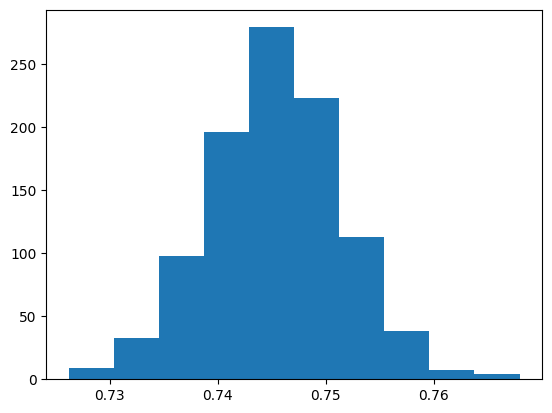

In [50]:
plt.hist([x[1]['firms']['min_price_breach'] for x in results])

(array([  25.,  142.,  624., 1629., 2653., 2518., 1577.,  648.,  155.,
          29.]),
 array([579.00016222, 583.18832299, 587.37648376, 591.56464452,
        595.75280529, 599.94096606, 604.12912682, 608.31728759,
        612.50544836, 616.69360912, 620.88176989]),
 <BarContainer object of 10 artists>)

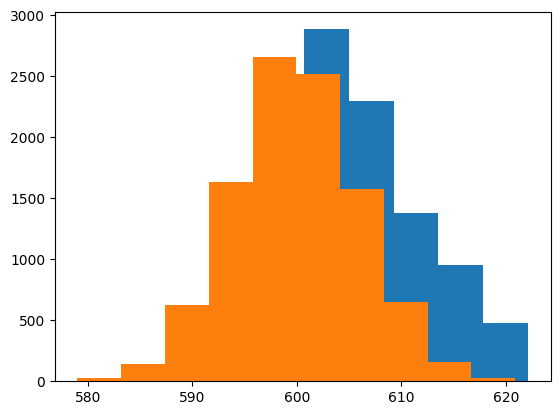

In [51]:
plt.hist(results[10][1]['firms']['firm_price'])
plt.hist(results[10][0]['firms']['firm_price'])

(array([  9.,  34.,  83., 175., 267., 214., 133.,  64.,  17.,   4.]),
 array([1287. , 1309.2, 1331.4, 1353.6, 1375.8, 1398. , 1420.2, 1442.4,
        1464.6, 1486.8, 1509. ]),
 <BarContainer object of 10 artists>)

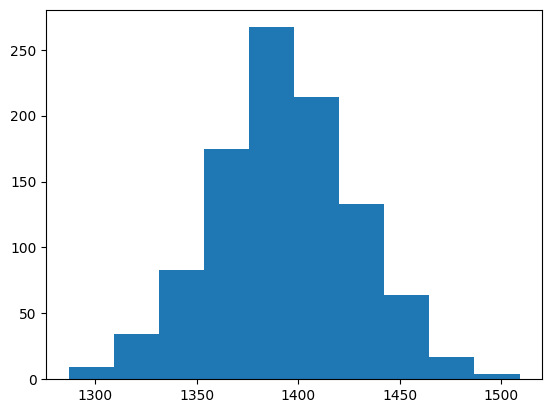

In [52]:
plt.hist([len(x[1]['firms']['defaulting_firms']) for x in results])

(array([788.,   0.,   0.,   0.,   0., 195.,   0.,   0.,   0.,  17.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

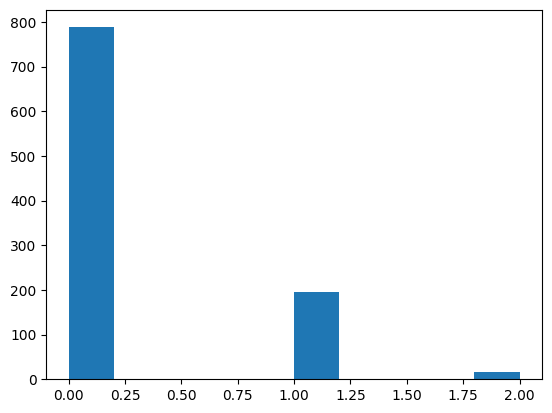

In [53]:
plt.hist([len(x[1]['banks']['defaulted_banks']) for x in results])